In [1]:
%%time
import pandas as pd
import numpy as np
import tfidf_matcher as tm
import datetime as dt
import time
import calendar
from difflib import SequenceMatcher
from functools import reduce

Wall time: 24 s


In [2]:
%%time

vmf_df= pd.read_csv('VMF_vendor_list.csv', sep='\t', encoding='utf-16')
access_rights_df = pd.read_csv('VMF_access_rights.csv', sep='\t', encoding='utf-16').dropna(how='all')
employees_df = pd.read_csv('VMF_employee_list.csv', sep='\t', encoding='utf-16').dropna(how='all')
terminated_employees_df = pd.read_csv('VMF_terminated_employees.csv', sep='\t', encoding='utf-16').dropna(how='all')
po_df = pd.read_csv('VMF_po_list.csv', sep='\t', encoding='utf-16').dropna(how='all')

Wall time: 545 ms


In [3]:
%%time

# Applying proper dtypes

vmf_df.name = vmf_df.name.astype(str)
vmf_df.creation_date = pd.to_datetime(vmf_df.creation_date)
vmf_df.modification_date = pd.to_datetime(vmf_df.modification_date)

employees_df.employee_name = employees_df.employee_name.astype(str)
employees_df.hiring_date = pd.to_datetime(employees_df.hiring_date)

terminated_employees_df.employee_name = terminated_employees_df.employee_name.astype(str)
terminated_employees_df.hiring_date = pd.to_datetime(terminated_employees_df.hiring_date)
terminated_employees_df.termination_date = pd.to_datetime(terminated_employees_df.termination_date)

po_df.po_date = pd.to_datetime(po_df.po_date)
po_df.po_total = po_df.po_total.str.replace(',', '').astype(int)

Wall time: 2.72 s


In [4]:
def similar(df, col1, col2):
    '''calculate similarities of returned results from tfidf matcher
    to facilitate filtering results'''
    return round(SequenceMatcher(None, df[col1], df[col2]).ratio(),2)

def similar_with_nan(df, col1, col2):
    '''calculate similarities between two dataframe columns while ignoring nan values'''
    if not df[[col1,col2]].isnull().any():
        return round(SequenceMatcher(None, df[col1], df[col2]).ratio(),2)
    else:
        return 0

def non_english_names(name):
    return name.isascii()

n_gram = 3
n_matches = 10

def employee_vs_vendor_records(vendor_df, employee_df, n_gram, n_matches):
    '''finding exact and fuzzy matches between employee and vendor names 
    based on user specified n_gram and number of desired matches 'n_matches'.
    n_gram and n_matches default values are 3 and 10 respectively which mostly yield best results
    results are not filtered but are sorted in a descending order for convenience.
    '''
    
    # identifying which datafram is loaded to properly name results while saving
    # as this function will be applied for both active and terminated employees
    
    employee_status = ''
    
    if employee_df is employees_df:
        employee_status= 'active'
    else:
        employee_status= 'terminated'
        
    # preparing list of names to match
    vendor_names_list = vendor_df.name.tolist()
    
    employee_names_list = employee_df.employee_name.tolist()
    
    # applying match function, adjusting data view and calculating similarities of returned results
    em_name_match_df=tm.matcher(employee_names_list, vendor_names_list, ngram_length= n_gram, k_matches= n_matches)

    em_name_match_df=pd.merge(em_name_match_df,employee_df[['employee_id']], left_index=True,right_index=True,how='left')

    em_name_match_df.drop_duplicates(subset='Original Name', inplace=True)

    em_name_match_df.drop(columns=['Match Confidence'], inplace=True)

    em_name_match_df.reset_index(drop=True, inplace=True)

    em_name_match_df=em_name_match_df.melt(id_vars=["Original Name", 'employee_id'],ignore_index=False)

    em_name_match_df.drop(columns=['variable'], inplace=True)
    
    em_name_match_df.reset_index(drop=True, inplace=True)

    em_name_match_df['similarity']=em_name_match_df.apply(similar,args=('Original Name', 'value'),axis=1)

    em_name_match_df.drop_duplicates(inplace=True)

    em_name_match_df.rename(columns={'value':'name'}, inplace=True)

    em_name_match_df.index=em_name_match_df.name

    vendor_df.index=vendor_df.name
    
    # collecting vendor details for matched vendors
    
    em_name_match_df=pd.merge(em_name_match_df,vendor_df[['id', 'vendor_status']], left_index=True,right_index=True,how='left')

    em_name_match_df.reset_index(drop=True, inplace=True)

    vendor_df.reset_index(drop=True, inplace=True)
    
    # removing reverse duplicate matches to eliminate data redundancy, 
    # i.e: match result of x,y and y,x basically refer to same records
    # first we join and sort both names to create a unique value for each result
    # then drop duplicate joined names
    
    em_name_match_df['reverse_duplicates'] = em_name_match_df.apply(lambda row: ' '.join(sorted([row['Original Name'], row['name']])), axis=1)

    em_name_match_df.drop_duplicates(subset='reverse_duplicates', inplace=True)

    em_name_match_df.drop(columns='reverse_duplicates', inplace=True)
    
    em_name_match_df.reset_index(drop=True, inplace=True)
    
    # collecting all employee/vendor details and sorting data for better view and comparison
    
    em_name_match_df=pd.merge(em_name_match_df,employee_df[['employee_id', 'phone', 'postal_code', 'address', 
                                                             'social_security_number_ssn']], on='employee_id', how='left')

    em_name_match_df.rename(columns={'Original Name':'employee_name', 'phone':'employee_phone', 'postal_code':'employee_postal_code', 'address':'employee_address',
                                     'social_security_number_ssn':'employee_ssn'}, inplace=True)

    em_name_match_df=pd.merge(em_name_match_df,vendor_df[['id', 'phone', 'postal_code', 'address', 
                                                       'taxpayer_identification_number_tin']], on='id', how='left')

    em_name_match_df.rename(columns={'id':'vendor_id', 'name':'vendor_name', 'phone':'vendor_phone', 
                                     'postal_code':'vendor_postal_code', 'address':'vendor_address', 
                                     'taxpayer_identification_number_tin':'vendor_tin'}, inplace=True)

    result_columns=em_name_match_df.columns.tolist()
    columns_sort=result_columns[1:2]+result_columns[0:1]+result_columns[2:3]+result_columns[4:5]+result_columns[3:4] \
    +result_columns[5:6]+result_columns[6:7]+result_columns[10:11]+result_columns[7:8]+result_columns[11:12]+result_columns[8:9] \
    +result_columns[12:13]+result_columns[9:10]+result_columns[13:]

    em_name_match_df=em_name_match_df[columns_sort].sort_values(by='similarity', ascending=False)
    
    # saving results based on type of dataframe loaded into the function
    
    if employee_status == 'active':
        em_name_match_df.to_csv('active_em_name_match.csv', index=False)
        r=em_name_match_df.copy()
    else:
        em_name_match_df.to_csv('terminated_em_name_match.csv', index=False)
        r=em_name_match_df.copy()
        
    return r

def weekday_or_weekend(date_col) :
    '''
    converting timestamp column to day number
    '''
    return dt.datetime.weekday(date_col)

# setting up weekend days based on day numbers
# Week starts on Monday: Monday is o - Sunday is 6
weekends = [4,5]

# setting up abnormal working hours
abnormal_working_hours = [20, 5]

In [5]:
%%time

#  vendor records exact and fuzzy matches

# finding exact and fuzzy matches between vendor names to identify possible duplicates
# based on user specified n_gram and number of desired matches 'n_matches'.
# n_gram and n_matches default values are 3 and 10 respectively which mostly yield best results
# results are not filtered but are sorted in a descending order for convenience.

# preparing list of names to match
vendor_name = vmf_df.name.tolist()

match_name = vmf_df.name.tolist()

# applying match function, adjusting data view and calculating similarities of returned results
vn_name_match_df=tm.matcher(vendor_name , match_name, ngram_length= n_gram, k_matches= n_matches)

vn_name_match_df=pd.merge(vn_name_match_df,vmf_df[['id']], left_index=True,right_index=True,how='left')

vn_name_match_df.drop_duplicates(subset='Original Name', inplace=True)

vn_name_match_df.drop(columns=['Match Confidence','Lookup 1'], inplace=True)

vn_name_match_df.reset_index(drop=True, inplace=True)

vn_name_match_df=vn_name_match_df.melt(id_vars=["Original Name", 'id'],ignore_index=False)

vn_name_match_df.drop(columns=['variable'], inplace=True)

vn_name_match_df.reset_index(drop=True, inplace=True)

vn_name_match_df['similarity']=vn_name_match_df.apply(similar,args=('Original Name', 'value'),axis=1)

vn_name_match_df.index=vn_name_match_df.value

vmf_df.index=vmf_df.name

# collecting vendor details for matched vendors
vn_name_match_df=pd.merge(vn_name_match_df,vmf_df[['id','vendor_status']], left_index=True,right_index=True,how='left')

vn_name_match_df.reset_index(drop=True, inplace=True)

vmf_df.reset_index(drop=True, inplace=True)

# remove duplicate records
temp_df=vn_name_match_df.groupby(['id_x','Original Name', 'id_y', 'value', 'similarity', 'vendor_status'])['value'].count().to_frame()

vn_name_match_df= temp_df.index.to_frame()

vn_name_match_df.reset_index(drop=True, inplace=True)

# remove exact id matches
vn_name_match_df=vn_name_match_df[vn_name_match_df.id_x != vn_name_match_df.id_y]

vn_name_match_df[['id_x','id_y']] = vn_name_match_df[['id_x','id_y']].astype(str)

# removing reverse duplicate matches to eliminate data redundancy, 
# i.e: match result of x,y and y,x basically refer to same records
# first we join and sort both vendor ids to create a unique value for each result
# then drop duplicate joined ids
vn_name_match_df['reverse_duplicates'] = vn_name_match_df.apply(lambda row: ''.join(sorted([row.id_x, row.id_y])), axis=1)

vn_name_match_df.drop_duplicates(subset='reverse_duplicates', inplace=True)

vn_name_match_df.drop(columns='reverse_duplicates', inplace=True)

vn_name_match_df.reset_index(drop=True, inplace=True)

# collecting all match vendor details and sorting data for better view and comparison
vn_name_match_df[['id_x','id_y']] = vn_name_match_df[['id_x','id_y']].astype(float)

vn_name_match_df.rename(columns={'id_x':'id','Original Name':'name'}, inplace=True)

vn_name_match_df=pd.merge(vn_name_match_df,vmf_df[['id', 'phone', 'postal_code', 'address', 
                                                   'taxpayer_identification_number_tin']], on='id', how='left')

vn_name_match_df.rename(columns={'id':'vendor_id','name':'vendor_name','phone':'vendor_phone', 
                                 'postal_code':'vendor_postal_code', 'address':'vendor_address', 
                                 'taxpayer_identification_number_tin':'vendor_tin'}, inplace=True)

vn_name_match_df.rename(columns={'id_y':'id','value':'name'}, inplace=True)

vn_name_match_df=pd.merge(vn_name_match_df,vmf_df[['id', 'phone', 'postal_code', 'address', 
                                                   'taxpayer_identification_number_tin']], on='id', how='left')

vn_name_match_df.rename(columns={'id':'match_vendor_id', 'name':'match_vendor_name', 'phone':'match_vendor_phone', 
                                 'postal_code':'match_vendor_postal_code', 'address':'match_vendor_address', 
                                 'taxpayer_identification_number_tin':'match_vendor_tin'}, inplace=True)

result_columns=vn_name_match_df.columns.tolist()

columns_sort=result_columns[:2]+result_columns[3:4]+result_columns[2:3]+result_columns[4:6]+result_columns[6:7] \
+result_columns[10:11]+result_columns[7:8]+result_columns[11:12]+result_columns[8:9]+result_columns[12:13] \
+result_columns[9:10]+result_columns[13:]

vn_name_match_df=vn_name_match_df[columns_sort].sort_values(by='similarity', ascending=False)

r1=vn_name_match_df.copy()

Wall time: 7.3 s


In [6]:
%%time

# Active employees records vs vendors records

r2 = employee_vs_vendor_records(vmf_df, employees_df, n_gram, n_matches)

Wall time: 7.04 s


In [7]:
%%time

# Terminated employees records vs vendors records

r3 = employee_vs_vendor_records(vmf_df, terminated_employees_df, n_gram, n_matches)

Wall time: 6.87 s


In [8]:
%%time

# lang_filter

r4 = vmf_df[~vmf_df['name'].apply(non_english_names)]

Wall time: 13 ms


In [9]:
%%time

# POs placed to employees
# identify all POs issued in the name of employees either active or terminated,
# using the results from previous functions and linking to po list
# both exact and fuzzy name matches are considered

active = pd.read_csv('active_em_name_match.csv')

terminated = pd.read_csv('terminated_em_name_match.csv')

# building the dataframe
# filtering close matches, according to difflib official documentation
# value over 0.6 means the sequences are close matches
fltrd_active_temp_df=active[active.similarity >= .6].copy()

fltrd_active_temp_df['employee_status']= 'Active'

fltrd_term_temp_df= terminated[terminated.similarity >= .6].copy()

fltrd_term_temp_df['employee_status']= 'Terminated'

employee_vs_po_list= fltrd_active_temp_df.append(fltrd_term_temp_df, ignore_index=True)

# mapping termination date to terminated employees
for i in employee_vs_po_list.employee_name.unique():
    
    term_date_dict=terminated_employees_df.set_index('employee_name').to_dict()['termination_date']
    
    if i in terminated_employees_df.employee_name.values:
        
        employee_vs_po_list['termination_date']=employee_vs_po_list.employee_name.map(term_date_dict)
        
    else:
        
        employee_vs_po_list['termination_date']= 'N/A'
            
employee_vs_po_list=pd.merge(employee_vs_po_list,po_df[['vendor_name','po_number','po_date','po_status','po_total', 'currency']], 
                             on='vendor_name', how='left')

# remove records of employees having no po issued in thier name
temp_df=employee_vs_po_list.groupby(['employee_id', 'employee_name', 'vendor_name', 'vendor_id','similarity', 
                                     'vendor_status', 'employee_status', 'termination_date','po_date', 'po_number',
                                     'po_status', 'po_total', 'currency'])['po_number'].count().to_frame()

employee_vs_po_list= temp_df.index.to_frame()

employee_vs_po_list.reset_index(drop=True, inplace=True)

r5=employee_vs_po_list.sort_values(by='similarity', ascending=False)

Wall time: 3.47 s


In [10]:
%%time

# access rights review
# identify any unauthorized record manipulation
# by comparing edit history to approved access rights and employee records

# building the dataframe
creation_temp_df = vmf_df[~vmf_df.creation_user_id.isin(access_rights_df.creation_user_id)]

modification_temp_df = vmf_df[~vmf_df.modification_user_id.isin(access_rights_df.modification_user_id)]

access_rights_review_df = creation_temp_df.append(modification_temp_df)

access_rights_review_df.reset_index(drop=True, inplace=True)

employees_df['employee_status'] = 'Active'

terminated_employees_df['employee_status'] = 'Terminated'

# adjusting column length to exact match in both dataframes
fltrt_term_df=terminated_employees_df[employees_df.columns]

temp_employee_df=employees_df.append(fltrt_term_df)

# collecting all active/terminated employee details and sorting data for better view and comparison
access_rights_review_df.index=access_rights_review_df.creation_user_id

temp_employee_df.index=temp_employee_df.employee_id

access_rights_review_df=pd.merge(access_rights_review_df,temp_employee_df[['departement', 'employee_status', 'employee_name']],
                                 left_index=True, right_index=True, how='left')

access_rights_review_df.rename(columns={'departement':'creation_user_departement', 'employee_status':'creation_user_status', 
                                        'employee_name':'creation_user_name'}, inplace=True)

access_rights_review_df.index=access_rights_review_df.modification_user_id

access_rights_review_df=pd.merge(access_rights_review_df,temp_employee_df[['departement', 'employee_status', 'employee_name']],
                                 left_index=True, right_index=True, how='left')

access_rights_review_df.rename(columns={'departement':'modification_user_departement', 
                                        'employee_status':'modification_user_status', 'employee_name':'modification_user_name',
                                        'id':'vendor_id', 'name':'vendor_name'}, inplace=True)

# mapping termination date to terminated employees
for i in access_rights_review_df.creation_user_id.unique():
    term_date_dict=terminated_employees_df.set_index('employee_id').to_dict()['termination_date']
    
    if i in terminated_employees_df.employee_id.values:
        access_rights_review_df['termination_date']=access_rights_review_df.creation_user_id.map(term_date_dict)
    else:
        access_rights_review_df['termination_date']=access_rights_review_df.modification_user_id.map(term_date_dict)

access_rights_review_df.reset_index(drop=True, inplace=True)

temp_employee_df.reset_index(drop=True, inplace=True)
    
result_columns=access_rights_review_df.columns.tolist()

columns_sort=result_columns[0:3]+result_columns[9:10]+result_columns[11:12]+result_columns[14:15]+result_columns[17:18] \
+result_columns[19:]+result_columns[10:11]+result_columns[13:14]+result_columns[15:16]+result_columns[12:13] \
+result_columns[16:17]+result_columns[18:19]

access_rights_review_df=access_rights_review_df[columns_sort]

r6=access_rights_review_df.copy()

Wall time: 558 ms


In [11]:
%%time

# Employees editing thier own vendor records
# both exact and fuzzy name matches are considered
# results are filtered to the nearest match

access_rights_review_df['similarity_creation'] = access_rights_review_df.apply(similar,args=('vendor_name', 'creation_user_name'),axis=1)

access_rights_review_df['similarity_modification'] = access_rights_review_df.apply(similar,args=('vendor_name', 'modification_user_name'),axis=1)

r7=access_rights_review_df[(access_rights_review_df.similarity_creation >= .6) | 
                           (access_rights_review_df.similarity_modification >= .6)]

Wall time: 104 ms


In [12]:
%%time

# Weekends modifications and at abnormal working hours

temp_vmf_df=vmf_df.copy()

temp_vmf_df['creation_hour'] = temp_vmf_df['creation_date'].dt.hour

temp_vmf_df['modification_hour'] = temp_vmf_df['modification_date'].dt.hour
    
temp_vmf_df['creation_day']=temp_vmf_df.creation_date.apply(weekday_or_weekend)

temp_vmf_df['modification_day']=temp_vmf_df.modification_date.apply(weekday_or_weekend)

# modifications on weekends
r8 = temp_vmf_df[(temp_vmf_df.creation_day.isin(weekends)) | (temp_vmf_df.modification_day.isin(weekends))]

result_columns=r8.columns.tolist()

columns_sort=result_columns[0:3]+result_columns[9:]

r8 = r8[columns_sort]

# late modifications after normal working hours,
# excluding records already identified in weekend modification to avoid duplication
if len(abnormal_working_hours) > 1 :
    if abnormal_working_hours[0] in np.arange(12,24):
    
        temp_creation_df = temp_vmf_df[(temp_vmf_df.creation_hour >= abnormal_working_hours[0]) | 
                                       (temp_vmf_df.creation_hour <= abnormal_working_hours[1])]

        temp_modification_df = temp_vmf_df[(temp_vmf_df.modification_hour >= abnormal_working_hours[0]) | 
                                           (temp_vmf_df.modification_hour <= abnormal_working_hours[1])]
    else:
    
        temp_creation_df = temp_vmf_df[(temp_vmf_df.creation_hour >= abnormal_working_hours[0]) & 
                                       (temp_vmf_df.creation_hour <= abnormal_working_hours[1])]

        temp_modification_df = temp_vmf_df[(temp_vmf_df.modification_hour >= abnormal_working_hours[0]) & 
                                           (temp_vmf_df.modification_hour <= abnormal_working_hours[1])]
else:
    temp_creation_df = temp_vmf_df[(temp_vmf_df.creation_hour == abnormal_working_hours[0])]

    temp_modification_df = temp_vmf_df[(temp_vmf_df.modification_hour == abnormal_working_hours[0])]
    
# filter out records already identified as abnormal creation hour
temp_modification_df = temp_modification_df[~temp_modification_df.id.isin(temp_creation_df.id)]

r9 = temp_creation_df.append(temp_modification_df)

r9.reset_index(drop=True, inplace=True)

result_columns=r9.columns.tolist()

columns_sort=result_columns[0:3]+result_columns[9:]

r9 = r9[columns_sort]

# filter out records already identified as weekend modification
r9 = r9[~r9.id.isin(r8.id)]

Wall time: 162 ms


In [13]:
%%time

# PO issued to inactive vendors

temp_po_df=po_df.copy()

# mapping vendor status to po list
vendor_status_dict=vmf_df.set_index('name').to_dict()['vendor_status']

temp_po_df['vendor_status']=temp_po_df.vendor_name.map(vendor_status_dict)

vmf_df.reset_index(drop=True, inplace=True)

r10 = temp_po_df[temp_po_df.vendor_status == 'In-Active'].sort_values(by='po_total', ascending=False)

Wall time: 188 ms


In [14]:
%%time

# Gaps in vendor id/po number sequential order and duplicate records

# building dataframe: vendor records

vendor_gaps_df=vmf_df.copy().sort_values(by='id')

vendor_gaps_df['start'] = vendor_gaps_df['id']

vendor_gaps_df['end'] = vendor_gaps_df['id'].shift(-1)

vendor_gaps_df['gap'] = vendor_gaps_df['id'].shift(-1) - vendor_gaps_df['id']


# building dataframe: po records

po_gaps_df=po_df.copy().sort_values(by='po_number')

po_gaps_df['start'] = po_gaps_df['po_number']

po_gaps_df['end'] = po_gaps_df['po_number'].shift(-1)

po_gaps_df['gap'] = po_gaps_df['po_number'].shift(-1) - po_gaps_df['po_number']


# vendor id gaps
r11 = vendor_gaps_df[(vendor_gaps_df['gap'] >0) & (vendor_gaps_df['gap'] != 1)]

# vendor id duplicates
r12 = vendor_gaps_df[(vendor_gaps_df['gap'] == 0)].dropna()

# po number gaps
r13 = po_gaps_df[(po_gaps_df['gap'] >0) & (po_gaps_df['gap'] != 1)]

# po number duplicates
r14 = po_gaps_df[(po_gaps_df['gap'] == 0)].dropna()

Wall time: 157 ms


In [15]:
%%time

# similarity across all vendor data
# considering only highest possible match

temp_vn_df = r1.copy()

temp_vn_df = temp_vn_df[temp_vn_df.similarity >= .6]

for i, e in zip(*[iter(temp_vn_df.columns[6:])] * 2):
    print('matching' + ' ' + i + ' ' + 'with' + ' ' + e)
    result = temp_vn_df.apply(similar_with_nan,args=(i,e),axis=1)
    temp_vn_df[i] = result
    temp_vn_df.drop(columns=e,inplace=True)

temp_vn_df['total_similarity_score'] = temp_vn_df['similarity'] + temp_vn_df.iloc[:,-5:-1].sum(axis=1)

r15 = temp_vn_df.copy().sort_values(by='total_similarity_score', ascending=False)

matching vendor_phone with match_vendor_phone
matching vendor_postal_code with match_vendor_postal_code
matching vendor_address with match_vendor_address
matching vendor_tin with match_vendor_tin
Wall time: 27.3 s


In [16]:
%%time

# similarity across all active employee vs vendor data
# considering only highest possible match

temp_emp_df=r2.copy()

temp_emp_df=temp_emp_df[temp_emp_df.similarity >= .6]

for i, e in zip(*[iter(temp_emp_df.columns[6:])] * 2):
    print('matching' + ' ' + i + ' ' + 'with' + ' ' + e)
    result=temp_emp_df.apply(similar_with_nan,args=(i,e),axis=1)
    temp_emp_df[i]= result
    temp_emp_df.drop(columns=e,inplace=True)

temp_emp_df['total_similarity_score'] = temp_emp_df['similarity'] + temp_emp_df.iloc[:,-5:-1].sum(axis=1)

r16 = temp_emp_df.copy().sort_values(by='total_similarity_score', ascending=False)

matching employee_phone with vendor_phone
matching employee_postal_code with vendor_postal_code
matching employee_address with vendor_address
matching employee_ssn with vendor_tin
Wall time: 808 ms


In [17]:
%%time

# similarity across all terminated employee vs vendor data
# considering only highest possible match

temp_termin_df=r3.copy()

temp_termin_df=temp_termin_df[temp_termin_df.similarity >= .6]

for i, e in zip(*[iter(temp_termin_df.columns[6:])] * 2):
    print('matching' + ' ' + i + ' ' + 'with' + ' ' + e)
    result=temp_termin_df.apply(similar_with_nan,args=(i,e),axis=1)
    temp_termin_df[i]= result
    temp_termin_df.drop(columns=e,inplace=True)

temp_termin_df['total_similarity_score'] = temp_termin_df['similarity'] + temp_termin_df.iloc[:,-5:-1].sum(axis=1)

r17 = temp_termin_df.copy().sort_values(by='total_similarity_score', ascending=False)

matching employee_phone with vendor_phone
matching employee_postal_code with vendor_postal_code
matching employee_address with vendor_address
matching employee_ssn with vendor_tin
Wall time: 742 ms


In [18]:
%%time

# terminated employees with highest number of POs placed after termination date
# exact matches are only considered

temp_term_df=r5.copy()

r18=temp_term_df[(temp_term_df.termination_date) < (temp_term_df.po_date)]

# filter for exact matches only

fltrd_r18=r18[r18.similarity == 1].copy()

earliest_po_date = fltrd_r18.groupby(['employee_id', 'employee_name', 'termination_date'])['po_date'].min().to_frame()

po_count_df = fltrd_r18.groupby(['employee_id', 'employee_name', 'termination_date'])['po_number'].count().to_frame()

po_value_df = fltrd_r18.groupby(['employee_id', 'employee_name', 'termination_date'])['po_total'].sum().to_frame()

df_list = [earliest_po_date, po_count_df, po_value_df, earliest_po_date.index.to_frame()]

r18_summary = reduce(lambda  left,right: pd.merge(left,right, left_index=True, right_index=True,
                                                 how='outer'), df_list).rename(columns={'po_date' : 'earliest_po_date', 
                                                                                        'po_number' : 'po_count', 
                                                                                        'po_total' : 'sum_po_values'})

result_columns=r18_summary.columns.tolist()

columns_sort=result_columns[3:]+result_columns[0:1]+result_columns[1:3]

r18_summary = r18_summary[columns_sort].sort_values(by='sum_po_values', ascending=False)

r18_summary.reset_index(drop=True, inplace=True)

Wall time: 451 ms


Wall time: 4.39 s


<AxesSubplot:ylabel='missing_records'>

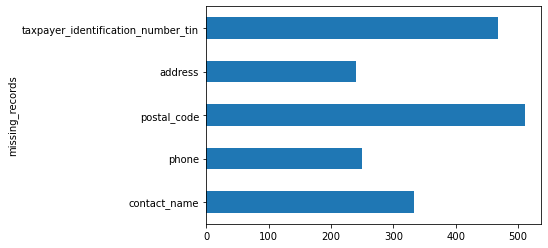

In [19]:
%%time

# missing vendor details

missing_details_count = vmf_df.isna().sum()

r19 = missing_details_count[missing_details_count > 0].to_frame()

r19 = pd.merge(r19.index.to_frame(), r19, left_index=True, right_index=True, 
               how='left').rename(columns={'0_x':'missing_records', '0_y':'missing_records_count'})

r19.reset_index(drop=True, inplace=True)

r19.plot(kind='barh', x= 'missing_records', y='missing_records_count', legend=False)

In [20]:
%%time

# summary of po details for inactive vendors 

temp_po_df= r10.copy()

po_count = temp_po_df.groupby('vendor_name')['po_number'].count().to_frame()

po_value = temp_po_df.groupby(['vendor_name', 'currency'])['po_total'].sum().to_frame()

df_list = [po_value, po_count, po_count.index.to_frame()]

r20 = reduce(lambda  left,right: pd.merge(left,right, left_index=True, right_index=True,
                                          how='outer'), df_list).rename(columns={'po_number': 'po_count',
                                                                                 'po_total': 'sum_po_values'})

r20.reset_index(drop=True, inplace=True)

result_columns=r20.columns.tolist()

columns_sort=result_columns[2:]+result_columns[1:2]+result_columns[0:1]

r20 = r20[columns_sort].sort_values(by='sum_po_values', ascending=False)

Wall time: 49 ms


In [21]:
%%time

# summary of weekend and abnormal working hours modifications 

# weekends modification

if len(weekends) > 1 :
    temp_days_creation = r8[(r8.creation_day == weekends[0]) | (r8.creation_day == weekends[1])]

    temp_days_modification = r8[(r8.modification_day == weekends[0]) | (r8.modification_day == weekends[1])]
else:
    temp_days_creation = r8[(r8.creation_day == weekends[0])]

    temp_days_modification = r8[(r8.modification_day == weekends[0])]

weekends_creation = temp_days_creation.groupby(['creation_user_id'])['creation_day'].count().to_frame()

weekends_modification = temp_days_modification.groupby(['modification_user_id'])['modification_day'].count().to_frame()

r21 = pd.merge(weekends_creation, weekends_creation.index.to_frame(), left_index=True, 
               right_index=True, how='left').rename(columns={'creation_day': 'created_records_count'})

r22 = pd.merge(weekends_modification, weekends_modification.index.to_frame(), left_index=True, 
               right_index=True, how='left').rename(columns={'modification_day': 'modified_records_count'})

r21['user_authorized'] = r21.creation_user_id.isin(access_rights_df.creation_user_id)

r22['user_authorized'] = r22.modification_user_id.isin(access_rights_df.modification_user_id)

result_columns=r21.columns.tolist()

columns_sort=result_columns[1:2]+result_columns[0:1]+result_columns[2:]

r21 = r21[columns_sort].sort_values(by='created_records_count', ascending = False)

result_columns=r22.columns.tolist()

columns_sort=result_columns[1:2]+result_columns[0:1]+result_columns[2:]

r22 = r22[columns_sort].sort_values(by='modified_records_count', ascending = False)

r21.reset_index(drop=True, inplace=True)
r22.reset_index(drop=True, inplace=True)

r23 = pd.merge(r21,r22, left_index=True, right_index=True, 
            how='outer').rename(columns={'user_authorized_x': 'creation_user_authorized',
                                         'user_authorized_y' : 'modification_user_authorized'})

Wall time: 275 ms


In [22]:
%%time

# summary abnormal working hours modification

abnormal_creation = temp_creation_df.groupby(['creation_user_id'])['creation_hour'].count().to_frame()
abnormal_modification = temp_modification_df.groupby(['modification_user_id'])['modification_hour'].count().to_frame()

r24 = pd.merge(abnormal_creation, abnormal_creation.index.to_frame(), left_index=True, 
               right_index=True, how='left').rename(columns={'creation_hour': 'created_records_count'})

r25 = pd.merge(abnormal_modification, abnormal_modification.index.to_frame(), left_index=True, 
               right_index=True, how='left').rename(columns={'modification_hour': 'modified_records_count'})

r24['user_authorized'] = r24.creation_user_id.isin(access_rights_df.creation_user_id)

r25['user_authorized'] = r25.modification_user_id.isin(access_rights_df.modification_user_id)

result_columns=r24.columns.tolist()

columns_sort=result_columns[1:2]+result_columns[0:1]+result_columns[2:]

r24 = r24[columns_sort].sort_values(by='created_records_count', ascending = False)

result_columns=r25.columns.tolist()

columns_sort=result_columns[1:2]+result_columns[0:1]+result_columns[2:]

r25 = r25[columns_sort].sort_values(by='modified_records_count', ascending = False)

r24.reset_index(drop=True, inplace=True)
r25.reset_index(drop=True, inplace=True)

r26 = pd.merge(r24,r25, left_index=True, right_index=True, 
            how='outer').rename(columns={'user_authorized_x': 'creation_user_authorized',
                                         'user_authorized_y' : 'modification_user_authorized'})

Wall time: 84 ms


In [23]:
%%time

# summary of modification by period

temp_period_df = vmf_df.copy()

creation = temp_period_df.groupby(['creation_date'])['creation_date'].count().resample('1y').sum().to_frame()

modification = temp_period_df.groupby(['modification_date'])['modification_date'].count().resample('1y').sum().to_frame()

creation = creation[creation.creation_date > 0]

modification = modification[modification.modification_date > 0]

r27 = pd.merge(creation, modification, left_index=True, right_index=True, how='outer')

r27 = pd.merge(r27.index.to_frame(), r27, left_index=True, right_index=True, how='outer')

r27.rename(columns={0: 'period', 'creation_date' : 'created_records_count', 
                    'modification_date' : 'modified_records_count'}, inplace=True)

r27.reset_index(drop=True, inplace=True)

r27= r27[(r27.created_records_count >= 0) | (r27.modified_records_count >= 0)]

Wall time: 456 ms


In [24]:
%%time

# summary of similarity across all vendor data,
# only exact and highest total similarities are considered,
# score of 2 and above provided best result filter.

r28 = r15[r15.total_similarity_score >= 2]

r28 = r28[r28.columns[0:4]]

r28.reset_index(drop=True, inplace=True)

Wall time: 14 ms


In [25]:
%%time

# summary of similarity across all active employee vs vendor data,
# only exact and highest total similarities are considered,
# score of 1.5 and above provided best result filter.

r29 = r16[(r16.similarity == 1) | (r16.total_similarity_score >= 1.5)]

r29 = r29[r29.columns[0:4]]

r29.reset_index(drop=True, inplace=True)

Wall time: 37 ms


In [26]:
%%time

# summary of similarity across all terminated employee vs vendor data, 
# only exact and highest total similarities are considered,
# score of 1.5 and above provided best result filter.

r30 = r17[(r17.similarity == 1) | (r17.total_similarity_score >= 1.5)]

r30 = r30[r30.columns[0:4]]

r30.reset_index(drop=True, inplace=True)

Wall time: 11 ms


In [27]:
%%time

# Saving Results

writer = pd.ExcelWriter('VMF_Analysed.xlsx', engine='xlsxwriter')

workbook = writer.book

worksheet = workbook.add_worksheet('summary_tables')

writer.sheets['summary_tables'] = worksheet

worksheet.hide_gridlines(2)

form = workbook.add_format()

form.set_align('center')

form.set_align('vcenter')

worksheet.set_column('A:G', 30, form)

chart = workbook.add_chart({'type': 'column'})

# Configure the series of the chart from the dataframe data.
chart.add_series({'categories': '=summary_tables!$A$3:$A$7',
                  'values': '=summary_tables!$B$3:$B$7',
                  'fill':   {'color': 'brown'},
                  'line': {'color': 'black'}})

# Insert the chart into the worksheet.
worksheet.insert_chart('C1', chart, {'x_scale': 1, 'y_scale': .5, 'x_offset': 25, 'y_offset': 10})

chart.set_legend({'position': 'none'})

# Configure the chart axes.
chart.set_x_axis({'name': 'Missing Data'})
chart.set_y_axis({'name': 'Count', 'major_gridlines': {'visible': False}})

worksheet.write(0, 0, 'Missing_vendor details')

r19.to_excel(writer, sheet_name = 'summary_tables', startrow=1 , startcol=0, index = False)

worksheet.write(r19.shape[0] + 3, 0, 'summary of vendors having highest similarities across all records')

r28.to_excel(writer, sheet_name = 'summary_tables', startrow= r19.shape[0] + 4 , startcol=0, index = False)

worksheet.write(r19.shape[0] + 3 + r28.shape[0] + 3, 0, 
                'summary of active employees and vendors having highest similarities across all records')

r29.to_excel(writer, sheet_name = 'summary_tables', startrow= r19.shape[0] + 3 + r28.shape[0] + 4 , startcol=0, 
             index = False)

worksheet.write(r19.shape[0] + 3 + r28.shape[0] + 3 + r29.shape[0] + 3, 0, 
                'summary of terminated employees and vendors having highest similarities across all records')

r30.to_excel(writer, sheet_name = 'summary_tables', startrow= r19.shape[0] + 3 + r28.shape[0] + 3 + r29.shape[0] + 4 , 
             startcol=0, index = False)

worksheet.write(r19.shape[0] + 3 + r28.shape[0] + 3 + r29.shape[0] + 3 + r30.shape[0] + 3, 0, 
                'Issued POs after employee termination date, only exact name matches are considered')

r18_summary.to_excel(writer, sheet_name = 'summary_tables', startrow= r19.shape[0] + 3 + r28.shape[0] + 3 + r29.shape[0] 
                     + 3 + r30.shape[0] + 4, startcol=0, index = False)

worksheet.write(r19.shape[0] + 3 + r28.shape[0] + 3 + r29.shape[0] + 3 + r30.shape[0] + 3 + r18_summary.shape[0] + 3, 0, 
                'Issued POs for inactive vendor')

r20.to_excel(writer, sheet_name = 'summary_tables', startrow= r19.shape[0] + 3 + r28.shape[0] + 3 + r29.shape[0] + 3 
             + r30.shape[0] + 3 + r18_summary.shape[0] + 4 , startcol=0, index = False)

worksheet.write(r19.shape[0] + 3 + r28.shape[0] + 3 + r29.shape[0] + 3 + r30.shape[0] + 3 + r18_summary.shape[0] + 3 
                + r20.shape[0] + 3, 0, 'Vendor records creation/modification on weekends')

r23.to_excel(writer, sheet_name = 'summary_tables', startrow= r19.shape[0] + 3 + r28.shape[0] + 3 + r29.shape[0] + 3 
             + r30.shape[0] + 3 + r18_summary.shape[0] + 3 + r20.shape[0] + 4 , startcol=0, index = False)

worksheet.write(r19.shape[0] + 3 + r28.shape[0] + 3 + r29.shape[0] + 3 + r30.shape[0] + 3 + r18_summary.shape[0] + 3 
                + r20.shape[0] + 3 + r23.shape[0] + 3, 0, 'Vendor records creation/modification at abnormal working hours')

r26.to_excel(writer, sheet_name = 'summary_tables', startrow= r19.shape[0] + 3 + r28.shape[0] + 3 + r29.shape[0] + 3 
             + r30.shape[0] + 3 + r18_summary.shape[0] + 3 + r20.shape[0] + 3 + r23.shape[0] + 4 , startcol=0, 
             index = False)

worksheet.write(r19.shape[0] + 3 + r28.shape[0] + 3 + r29.shape[0] + 3 + r30.shape[0] + 3 + r18_summary.shape[0] + 3 
                + r20.shape[0] + 3 + r23.shape[0] + 3 + r26.shape[0] + 3, 0, 
                ' Summary of vendor records creation/modification by period')

r27.to_excel(writer, sheet_name = 'summary_tables', startrow= r19.shape[0] + 3 + r28.shape[0] + 3 + r29.shape[0] + 3 
             + r30.shape[0] + 3 + r18_summary.shape[0] + 3 + r20.shape[0] + 3 + r23.shape[0] + 3 + r26.shape[0] + 4 , 
             startcol=0, index = False)

r1.to_excel(writer, sheet_name = 'vendor_name_match', index = False)

r2.to_excel(writer, sheet_name = 'active_emp_vs_ven_name_match', index = False)

r3.to_excel(writer, sheet_name = 'term_emp_vs_ven_name_match', index = False)

r4.to_excel(writer, sheet_name = 'non_english_ven_names', index = False)

r5.to_excel(writer, sheet_name = 'po_to_employees', index = False)

r6.to_excel(writer, sheet_name = 'unauthorized_access', index = False)

r7.to_excel(writer, sheet_name = 'employees_editing_own_records', index = False)

r8.to_excel(writer, sheet_name = 'weekend_modifications', index = False)

r9.to_excel(writer, sheet_name = 'abnormal_hours_modifications', index = False)

r10.to_excel(writer, sheet_name = 'po_for_inactive_vendors', index = False)

r11.to_excel(writer, sheet_name = 'gabs_vendor_id', index = False)

r12.to_excel(writer, sheet_name = 'duplicate_vendor_id', index = False)

r13.to_excel(writer, sheet_name = 'gabs_po_number', index = False)

r14.to_excel(writer, sheet_name = 'duplicate_po_number', index = False)

r15.to_excel(writer, sheet_name = 'similarity_all_vendor_details', index = False)

r16.to_excel(writer, sheet_name = 'similarity_all_emp_ven_details', index = False)

r17.to_excel(writer, sheet_name = 'similarity_all_term_ven_details', index = False)

r18.to_excel(writer, sheet_name = 'po_date_after_emp_term_date', index = False)

writer.save()